In [1]:
from collections import defaultdict
import io
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import json
import random
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anvitasrinivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def string_processing(s):
    exclude = set(string.punctuation)
    new_s = ''.join(ch for ch in s.lower() if ch not in exclude)
    return new_s

In [3]:
def parse_line(line):
    values = line.strip().split(' +++$+++ ')
    columns = ['movie_id', 'title', 'release_year', 'rating', 'num_votes', 'genres']
    metadata = dict(zip(columns, values))
    
    metadata['release_year'] = int(metadata['release_year'][:4])
    metadata['rating'] = float(metadata['rating']) 
    metadata['num_votes'] = int(metadata['num_votes'])  
    
    exclude = set(string.punctuation)
    genres = ''.join(ch for ch in metadata['genres'] if ch not in exclude).split()
    metadata['genres'] = genres
    return metadata

In [4]:
metadataMovies = defaultdict(dict)
moviesPerGenre = defaultdict(list)
ratingsPerGenre = defaultdict(list)
watchersPerGenre = defaultdict(int)
lines = io.open('cornell/movie_titles_metadata.txt',mode='r', encoding='latin-1').readlines()
for line in lines:
    metadata = parse_line(line)
    metadataMovies[metadata['movie_id']] = metadata
    for genre in metadata['genres']:
        moviesPerGenre[genre].append(metadata['movie_id'])
        ratingsPerGenre[genre].append(metadata['rating'])
        watchersPerGenre[genre] += metadata['num_votes']       

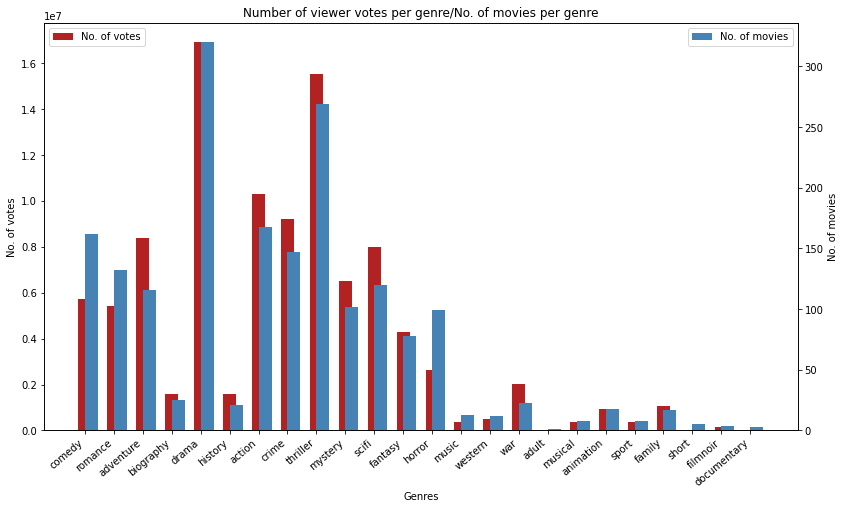

In [5]:
# Distribution of movie genres
genres = [genre for genre in moviesPerGenre]
movies_per_genre = [len(moviesPerGenre[g]) for g in moviesPerGenre]

fig, ax1 = plt.subplots()
ax1.set_title('Number of viewer votes per genre/No. of movies per genre')
ax1.set_xlabel('Genres')
ax1.bar(genres, watchersPerGenre.values(), color='firebrick', 
        width=0.45, align='center', label='No. of votes')
ax1.set_ylabel('No. of votes')
plt.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(genres, movies_per_genre, color='steelblue', 
        width=0.45, align='edge', label='No. of movies')
ax2.set_ylabel('No. of movies')
plt.legend(loc='upper right')

plt.setp(ax1.get_xticklabels(), rotation=40, horizontalalignment='right')
fig.set_size_inches(13.5, 7.5)
plt.show()



In [6]:
# Co-occurence of genres

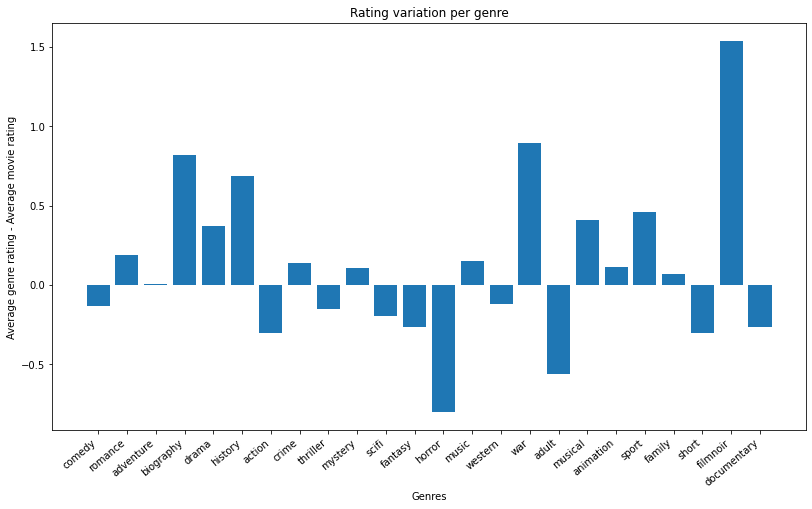

In [7]:
# Average rating per genre
all_ratings = [metadataMovies[m]['rating'] for m in metadataMovies]
mean_rating = np.mean(all_ratings)
rating_variation_per_genre = [np.mean(ratingsPerGenre[g]) - mean_rating for g in ratingsPerGenre]

fig, ax = plt.subplots()
ax.set_title('Rating variation per genre')
ax.bar(genres, rating_variation_per_genre)
ax.set_xlabel('Genres')
ax.set_ylabel('Average genre rating - Average movie rating')
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
fig.set_size_inches(13.5, 7.5)
plt.show()

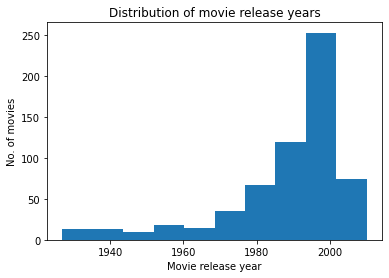

In [8]:
# Distribution of movie release years
movie_release_years = [metadataMovies[m]['release_year'] for m in metadataMovies]

plt.title('Distribution of movie release years')
plt.hist(movie_release_years)
plt.xlabel('Movie release year')
plt.ylabel('No. of movies')
plt.show()

In [9]:
movieCharacters = defaultdict(list)
lines = io.open('cornell/movie_characters_metadata.txt',mode='r', encoding='latin-1').readlines()
for line in lines:
    values = line.strip().split(' +++$+++ ')
    movieCharacters[values[2]].append(values[1].strip())

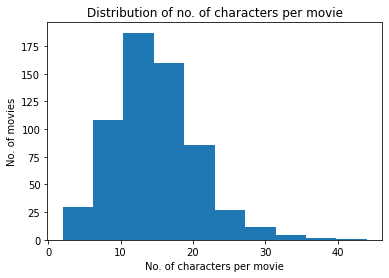

In [10]:
# Distribution of number characters per movie
num_characters_per_movie = [len(movieCharacters[m]) for m in movieCharacters] 

plt.title('Distribution of no. of characters per movie')
plt.hist(num_characters_per_movie)
plt.xlabel('No. of characters per movie')
plt.ylabel('No. of movies')
plt.show()

In [11]:
lineMapping = defaultdict()
lines = io.open('cornell/movie_lines.txt',mode='r', encoding='latin-1').readlines()
for line in lines:
    values = line.strip().split(' +++$+++ ')
    if len(values) == 5:
        lineMapping[values[0]] = values[4]
    else:
        lineMapping[values[0]] = ''

In [12]:
import ast
conversationMovieMapping = defaultdict(list)
conversations = []
lines = io.open('cornell/movie_conversations.txt',mode='r', encoding='latin-1').readlines()
for line in lines:
    values = line.strip().split(' +++$+++ ')
    conv = [n.strip() for n in ast.literal_eval(values[3])]
    conversationForMovie = [lineMapping[x] for x in conv]
    conversations.append((conversationForMovie, values[2]))
    conversationMovieMapping[values[2]].append(conversationForMovie)    

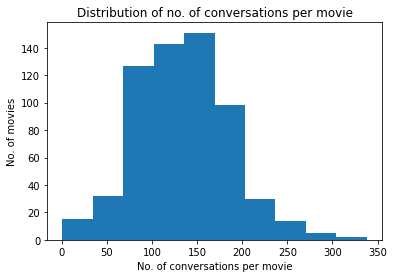

In [13]:
# Distribution of number of coversations per movie
num_conv_per_movie = [len(conversationMovieMapping[m]) for m in conversationMovieMapping] 

plt.title('Distribution of no. of conversations per movie')
plt.hist(num_conv_per_movie)
plt.xlabel('No. of conversations per movie')
plt.ylabel('No. of movies')
plt.show()

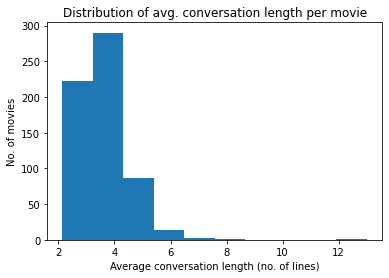

In [14]:
# Distribution of average conversation length per movie
conversation_lengths = {m:[len(conv) for conv in conversationMovieMapping[m]] for m in conversationMovieMapping}
average_conv_length = [np.mean(conversation_lengths[m]) for m in conversation_lengths]

plt.title('Distribution of avg. conversation length per movie')
plt.hist(average_conv_length)
plt.xlabel('Average conversation length (no. of lines)')
plt.ylabel('No. of movies')
plt.show()

In [15]:
completeDataset = open('completeDataset.txt','w+')
for mov in metadataMovies:
    line = mov + ' +++$+++ '
    line += ' +++$+++ '.join(metadataMovies[mov])
    line += ' +++$+++ '
    if len(movieCharacters[mov]) > 0:
        line += str(movieCharacters[mov])
    else:
        line += 'N/A'
    line += ' +++$+++ '
    if len(conversationMovieMapping[mov]) > 0:
        line += str(conversationMovieMapping[mov])
    else:
        line += 'N/A'
    
    line += '\n'
    
    completeDataset.write(line)
completeDataset.close()

In [16]:
mapping = defaultdict()
for line in open('completeDataset.txt','r'):
    values = line.split(' +++$+++ ')
    mapping[values[0]] = values[1:]
    
count = 0

In [17]:
data = {}
for m in metadataMovies:
    data[m] = metadataMovies[m].copy()
    data[m]['characters'] = movieCharacters[m]
    data[m]['conversations'] = conversationMovieMapping[m]

with open('conversation_dataset.json', 'w') as f:
    json.dump(data , f)

In [18]:
with open("conversation_dataset.json", "r") as f:
    dataset = json.load(f)
print(len(list(dataset.keys())))

617


In [19]:
convosDataset = []
for mKey in dataset:
    conversationsOfMovie = dataset[mKey]['conversations']
    metadata = dataset[mKey].copy()
    metadata.pop('conversations', None)
    convosDataset.extend([dict(**metadata, **{'dialogue': conv}) for conv in conversationsOfMovie])

## ––––––––––––––––––––––– Model start –––––––––––––––––––––––

In [20]:
len(convosDataset)

83097

In [21]:
train = convosDataset[:int(0.8*len(convosDataset))]
test = convosDataset[int(0.8*len(convosDataset)):]

In [22]:
print(len(train))

66477


In [23]:
random.shuffle(train)
random.shuffle(test)

## Feature Engineering

In [24]:
genres = [genre for genre in moviesPerGenre]
genre_to_index = dict(zip(genres, range(len(genres))))

def encode_genres(d):
    encoding = np.zeros(len(genres))
    for genre in d['genres']:
         encoding[genre_to_index[genre]] = 1
    return encoding

In [25]:
min_release_year = min([d['release_year'] for d in train])

def transform_release_year(d):
    return d['release_year'] - min_release_year

In [26]:
avg_rating = np.mean([d['rating'] for d in train])

def transform_rating(d):
    return d['rating'] - avg_rating

In [27]:
avg_num_votes = np.mean([d['num_votes'] for d in train])

def transform_num_votes(d):
    return d['num_votes'] - avg_num_votes

In [28]:
# Fit TfidfVectorizer to all the movie titles 
movie_titles = [d['title'] for d in train]
vectorizer = TfidfVectorizer()
fit_vectorizer_title = vectorizer.fit(movie_titles)

def transform_title(d):
    return fit_vectorizer_title.transform([d['title']]).toarray()

In [29]:
title_feature_names = vectorizer.get_feature_names_out()
print(title_feature_names[200:220])

['domino' 'donnie' 'doom' 'dr' 'dragon' 'dream' 'dreams' 'driver' 'drop'
 'drunk' 'duck' 'dumb' 'dumberer' 'dune' 'durham' 'dusk' 'earth' 'easy'
 'ed' 'edtv']


In [30]:
# Fit TfidfVectorizer to all the movie dialogues 
stop_words = set(stopwords.words('english'))
movie_dialogues = [' '.join(d['dialogue']) for d in train]
# movie_dialogues = [string_processing(s) for s in movie_dialogues]
vectorizer = TfidfVectorizer(stop_words=stop_words, 
                             min_df=10,
                             max_features=3000)
fit_vectorizer_dialogue = vectorizer.fit(movie_dialogues)

def transform_dialogues(d):
    dialogue = ' '.join(d['dialogue'])
    return fit_vectorizer_dialogue.transform([dialogue]).toarray()

In [31]:
dialogue_feature_names = vectorizer.get_feature_names_out()
print(dialogue_feature_names[100:120])

['anyone' 'anything' 'anytime' 'anyway' 'anywhere' 'apart' 'apartment'
 'apologize' 'apparently' 'appear' 'appears' 'apple' 'appointment'
 'appreciate' 'approach' 'area' 'argue' 'argument' 'arm' 'armed']


In [32]:
# Fit TfidfVectorizer to all the movie character names 
movie_characters = [' '.join(d['characters']) for d in train]
vectorizer = TfidfVectorizer(min_df=0.03)
fit_vectorizer_chars = vectorizer.fit(movie_characters)

def transform_characters(d):
    characters = ' '.join(d['characters'])
    return fit_vectorizer_chars.transform([characters]).toarray()

In [33]:
print(vectorizer.get_feature_names_out())

['agent' 'big' 'bill' 'billy' 'bob' 'boy' 'captain' 'charlie' 'chief'
 'clerk' 'cop' 'david' 'detective' 'doctor' 'dr' 'driver' 'father' 'frank'
 'george' 'girl' 'guard' 'harry' 'helen' 'jack' 'jennifer' 'jim' 'jimmy'
 'joe' 'john' 'judge' 'kid' 'man' 'manager' 'mary' 'max' 'michael' 'miss'
 'mom' 'mother' 'mr' 'mrs' 'nick' 'nurse' 'officer' 'old' 'paul' 'peter'
 'president' 'ray' 'rose' 'sam' 'sarah' 'secretary' 'the' 'tommy' 'voice'
 'woman' 'young']


In [34]:
def build_feature(d, selector=[1, 1, 1, 1, 1, 1]):
    features = []
    if selector[0] == 1:
        features.append([transform_release_year(d)])
    if selector[1] == 1:
        features.append([transform_rating(d)])
    if selector[2] == 1:
        features.append([transform_num_votes(d)])
    if selector[3] == 1:
        features.extend(transform_title(d))
    if selector[4] == 1:
        features.extend(transform_dialogues(d))
    if selector[5] == 1:
        features.extend(transform_characters(d))
        
    feature = np.concatenate(features, axis=0)
    return np.array(feature)

In [35]:
d = train[2]
print(d)

{'movie_id': 'm454', 'title': 'natural born killers', 'release_year': 1994, 'rating': 7.1, 'num_votes': 73047, 'genres': ['action', 'crime', 'drama', 'romance', 'thriller'], 'characters': ['GRACE', 'MABEL', 'MALLORY', 'MCCLUSKY', 'MICKEY', 'MOVIE MALLORY', 'MOVIE MICKEY', 'NORMAN', 'PITNEY', 'ROGER', 'SCAGNETTI', 'SCOTT', 'SIMON', 'WAYNE', 'WURLITZER'], 'dialogue': ['Why are Mickey and Mallory being moved to an asylum? And who made the decision?', "The prison board made the decision. A board of which I belong. We're the who. The why is simple. Mickey and Mallory are mentally ill and need to be under a doctor's care, where hopefully they'll receive the help they need.", "Mickey and Mallory were deemed competent in a mental examination before their trial. I'm confused. What's changed?", "Well, since that time, they've killed one person during their trail. And since their incarceration, they've killed one psychologist along with several guards and inmates.", "When they were found competen

In [36]:
a = build_feature(d)
a.shape

(3847,)

## Training 

In [37]:
X_train = [build_feature(d) for d in train] 
y_train = [encode_genres(d) for d in train] 

X_test = [build_feature(d) for d in test] 
y_test = [encode_genres(d) for d in test] 